In [197]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
#from pixell import reproject
#from classy import Class
import ST

In [198]:
nside = 256

In [199]:
lmax  = 3*nside -1 

In [200]:
func = np.ones (lmax +1)
func [1] =1

In [42]:
alm_size = hp.Alm.getsize (lmax = lmax)
alm_size

295296

In [43]:
alm = np.zeros (alm_size)
alm[:lmax+1] = 1
#alm[0] = 2

In [44]:
result = hp.almxfl(alm , func)
result 

array([1.+0.j, 1.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [48]:
map_result  = hp.alm2map (result , nside= nside)
map_result

array([2.79138661e+03, 2.79138661e+03, 2.79138661e+03, ...,
       2.04589828e-01, 2.04589828e-01, 2.04589828e-01])

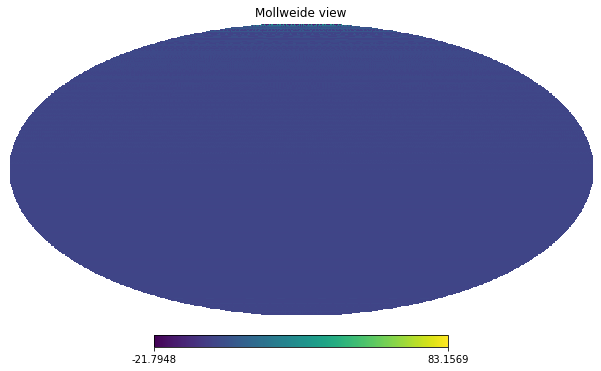

In [47]:
hp.mollview  (map_result)

In [52]:
nside_0256 = nside
lmax_0256 = lmax


res_0256 = hp.nside2resol (nside_0256 , arcmin = False)
res_0256_arcmin = hp.nside2resol (nside_0256 , arcmin = True)
theta_bin = 10000
jmax = int(np.floor(np.log(2*np.pi *0.75 /res_0256 / 2)/np.log(2)))
print(jmax)


morl_array = ST.morlet_arr (res_0256 , jmax , lmax_0256 , theta_bin)

9


/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1242: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1243: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1247: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


In [160]:
ralm = hp.almxfl (alm , morl_array [0])
map_mor = hp.alm2map (ralm, nside)
r = hp.rotator.Rotator(rot=[0,90,], eulertype='ZYX')
map_mor = r.rotate_map_pixel(map_mor)

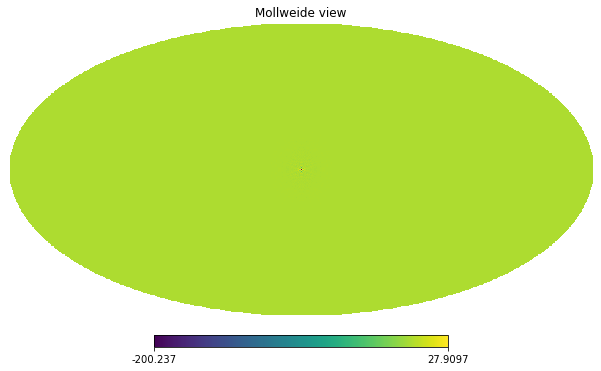

In [161]:
hp.mollview (map_mor )

In [66]:
#Gabor filter

def gabor_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Gabor filter.
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        freq : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        offset : int, optional
            offset by which the signal starts
        Returns
        -------
        gabor_2d : ndarray
            numpy array of size (M, N)
    """
    gab = np.zeros((M, N), np.complex64)
    [x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    #print ()
    arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2+y**2)
    #print (arg.shape)
    gab += np.exp(arg)

    norm_factor = (2 * np.pi * sigma * sigma)
    gab /= norm_factor

    return gab

In [67]:
def morlet_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Morlet filter.
        A Morlet filter is the sum of a Gabor filter and a low-pass filter
        to ensure that the sum has exactly zero mean in the temporal domain.
        It is defined by the following formula in space:
        psi(u) = g_{sigma}(u) (e^(i xi^T u) - beta)
        where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
        the cancelling parameter.
        Parameters
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        xi : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        Returns
        -------
        morlet_2d : ndarray
            numpy array of size (M, N)
    """
    wv = gabor_2d(M, N, sigma,  freq)
    wv_modulus = gabor_2d(M, N, sigma, 0)
    K = np.sum(wv) / np.sum(wv_modulus)

    mor = wv - K * wv_modulus
    return mor

In [211]:
theta_arr = np.linspace(0, np.pi, num=x_dim)[:, None]

#theta_arr1 = np.linspace(0, np.pi/2, num=int (x_dim/2))[:, None]
#theta_arr2 = np.linspace( np.pi/2 , np.pi, num=int (x_dim/2))[:, None]

phi_arr = np.linspace(-np.pi, np.pi, num=y_dim)

In [212]:
j = 11
x_dim = 1000
y_dim = 1000

sigma=0.8*2**j
freq=(3*np.pi)/(4.*2**j)
mor = morlet_2d (x_dim, y_dim, sigma, freq)

In [213]:
#pix1 = hp.ang2pix(nside_0256, theta_arr1, phi_arr)
#pix2 = hp.ang2pix(nside_0256, theta_arr2, phi_arr)
pix = hp.ang2pix(nside_0256, theta_arr, phi_arr)

map_morlet_proj = np.zeros(hp.nside2npix(nside_0256), dtype="float")
map_morlet_proj[pix] = np.abs (mor)

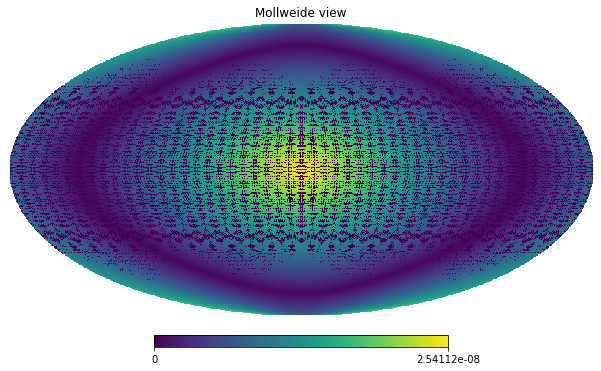

In [214]:
hp.mollview(map_morlet_proj )

In [116]:
map_mor /= np.sum (map_mor)
map_morlet_proj /= np.sum(map_morlet_proj)

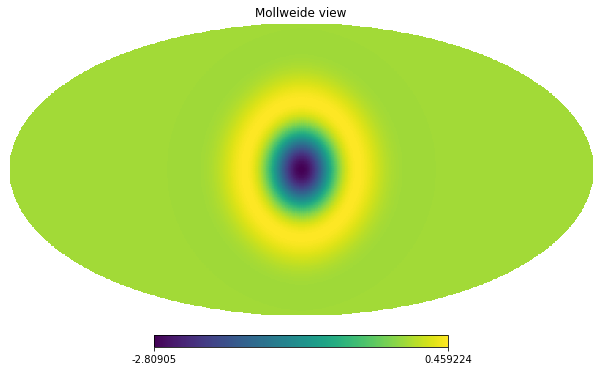

In [124]:

npix = np.arange (map_mor.shape[0])

theta , phi = hp.pix2ang (nside= nside , npix )


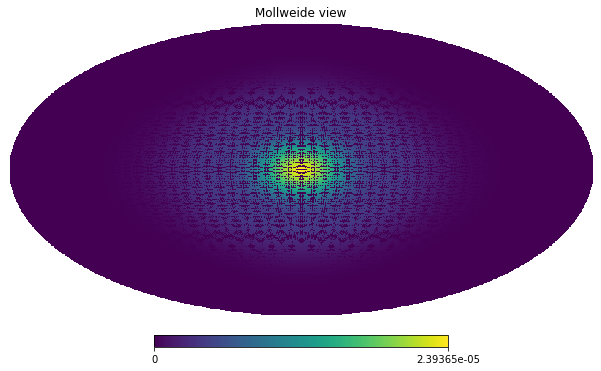

In [188]:
hp.mollview(map_morlet_proj)

In [185]:

theta_arr_tmp = np.linspace (0,np.pi , 1000000)
morlet_map = ST.morlet (freq, sigma, theta_arr_tmp, lmax_0256)

In [186]:
morlet_direct_map = np.zeros(map_mor.shape[0])
for i, theta in enumerate(theta_arr) :
    pix= hp.ang2pix(nside , theta, phi_arr)
    morlet_direct_map [pix] = morlet_map[i]

<ipython-input-186-565b6d6a5738>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  morlet_direct_map [pix] = morlet_map[i]


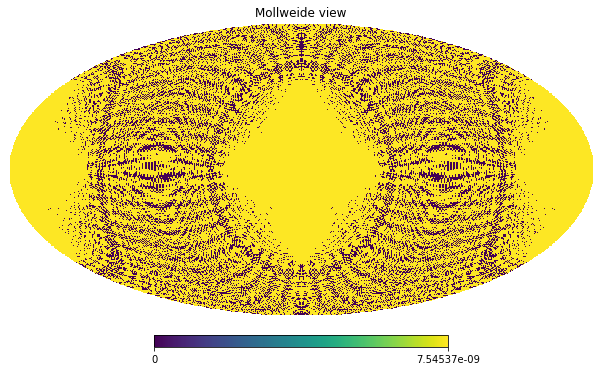

In [187]:
hp.mollview(morlet_direct_map, rot=[0,90])

In [192]:
bl = np.ones (lmax_0256+1)
hp.bl2beam (bl,theta_arr)


array([[ 4.69367026e+04,  4.69367026e+04,  4.69367026e+04, ...,
         4.69367026e+04,  4.69367026e+04,  4.69367026e+04],
       [ 2.00910681e+04,  2.00910681e+04,  2.00910681e+04, ...,
         2.00910681e+04,  2.00910681e+04,  2.00910681e+04],
       [-5.90326263e+03, -5.90326263e+03, -5.90326263e+03, ...,
        -5.90326263e+03, -5.90326263e+03, -5.90326263e+03],
       ...,
       [ 1.41358633e+01,  1.41358633e+01,  1.41358633e+01, ...,
         1.41358633e+01,  1.41358633e+01,  1.41358633e+01],
       [ 3.27119108e-01,  3.27119108e-01,  3.27119108e-01, ...,
         3.27119108e-01,  3.27119108e-01,  3.27119108e-01],
       [-6.11154981e+01, -6.11154981e+01, -6.11154981e+01, ...,
        -6.11154981e+01, -6.11154981e+01, -6.11154981e+01]])